In [63]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import SGD
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

In [64]:
tensor1 = torch.tensor([[1, 2], [3, 4]])
print(tensor1)
tensor2 = torch.tensor([[5, 6], [7, 8]])
print(tensor2)
x = tensor1 + 5
print(x)
y = tensor1 * 2
print(y)
z = tensor1.t()
print(z)
print(tensor1 + tensor2)
print(tensor1 * tensor2)

tensor([[1, 2],
        [3, 4]])
tensor([[5, 6],
        [7, 8]])
tensor([[6, 7],
        [8, 9]])
tensor([[2, 4],
        [6, 8]])
tensor([[1, 3],
        [2, 4]])
tensor([[ 6,  8],
        [10, 12]])
tensor([[ 5, 12],
        [21, 32]])


In [65]:
transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
test_dataset = datasets.MNIST(root = './data', train = False, download = True, transform = transform)

In [66]:
x_train = []
y_train = []
for x, y in train_dataset:
    x_train.append(x)
    y_train.append(y)

In [67]:
x_test = []
y_test = []
for x, y in test_dataset:
    x_test.append(x)
    y_test.append(y)

In [68]:
y_train = F.one_hot(torch.tensor(y_train), num_classes = 10).to(float)
y_test = F.one_hot(torch.tensor(y_test), num_classes = 10).to(float)

In [69]:
x_train = torch.cat(x_train, dim = 0)
x_test = torch.cat(x_test, dim = 0)

In [70]:
train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)

In [71]:
train_dl = DataLoader(train_ds, batch_size = 5)
test_dl = DataLoader(test_ds, batch_size = 5)

In [72]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 = nn.Linear(32 * 32, 100)
        self.Linear2 = nn.Linear(100, 50)
        self.Linear3 = nn.Linear(50, 10)
        self.R = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim = 1)
    def forward(self, x):
        x = x.view(-1, 32 * 32)
        x = self.R(self.Linear1(x))
        x = self.R(self.Linear2(x))
        x = self.R(self.Linear3(x))
        self.softmax = nn.LogSoftmax(dim = 1)
        return x.squeeze()

In [73]:
f = MyNeuralNet()

In [74]:
def train_model(dl, f, n_epochs = 20):
    opt = SGD(f.parameters(), lr = 0.01)
    L = nn.CrossEntropyLoss()
    losses = []
    epochs = []
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}')
        N = len(dl)
        for i, (x, y) in enumerate(dl):
            opt.zero_grad()
            loss_value = L(f(x), y)
            loss_value.backward()
            opt.step()
            epochs.append(epoch + i / N)
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

In [75]:
epoch_data, loss_data = train_model(train_dl, f)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


In [76]:
epoch_data_avgd = epoch_data.reshape(20, -1).mean(axis = 1)
loss_data_avgd = loss_data.reshape(20, -1).mean(axis = 1)

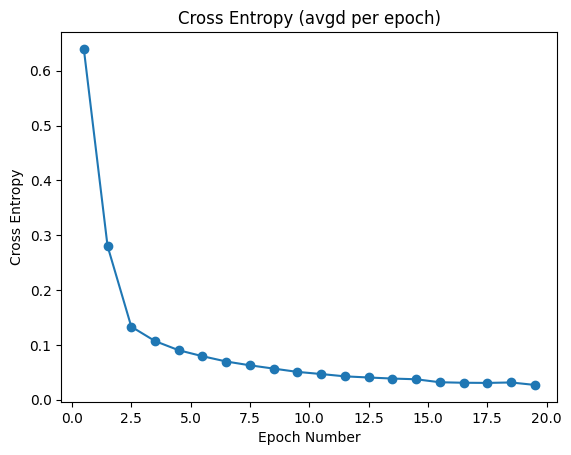

In [77]:
plt.plot(epoch_data_avgd, loss_data_avgd, 'o-')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')
plt.show()

<ipython-input-78-87b24f03b1bf>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(7, 5, i + 1)


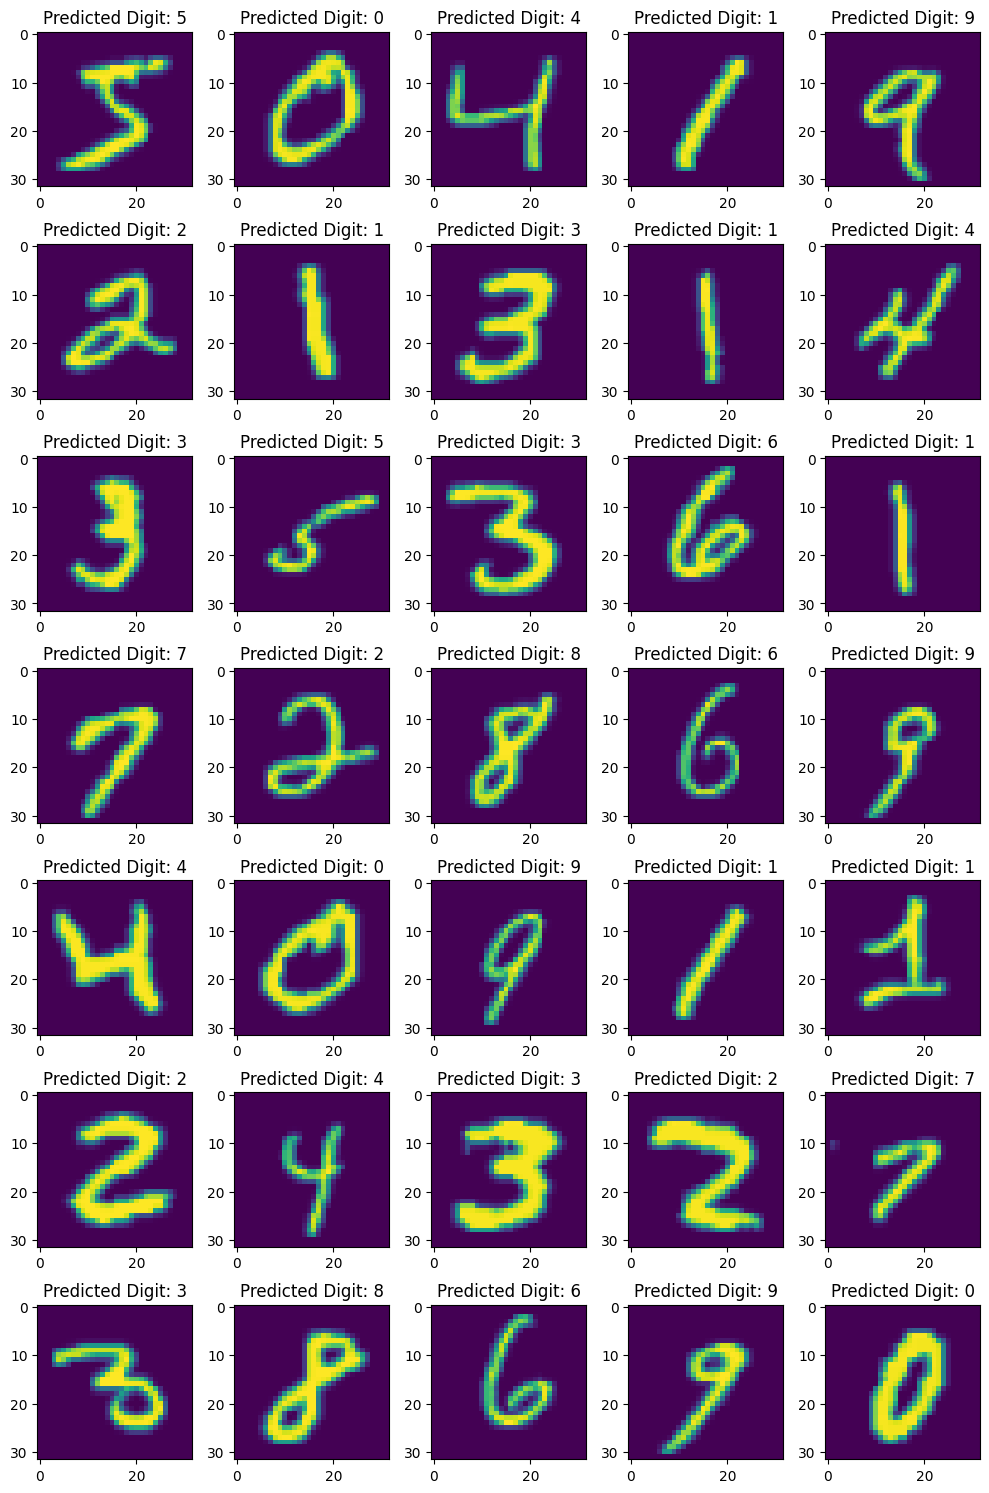

In [78]:
xs, ys = train_ds[0:2000]
ypred = f(xs).argmax(axis = 1)
fig, ax = plt.subplots(10, 4, figsize = (10, 15))
for i in range(35):
    plt.subplot(7, 5, i + 1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {ypred[i]}')
fig.tight_layout()
plt.show()

<ipython-input-79-08bd5539428f>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(7, 5, i + 1)


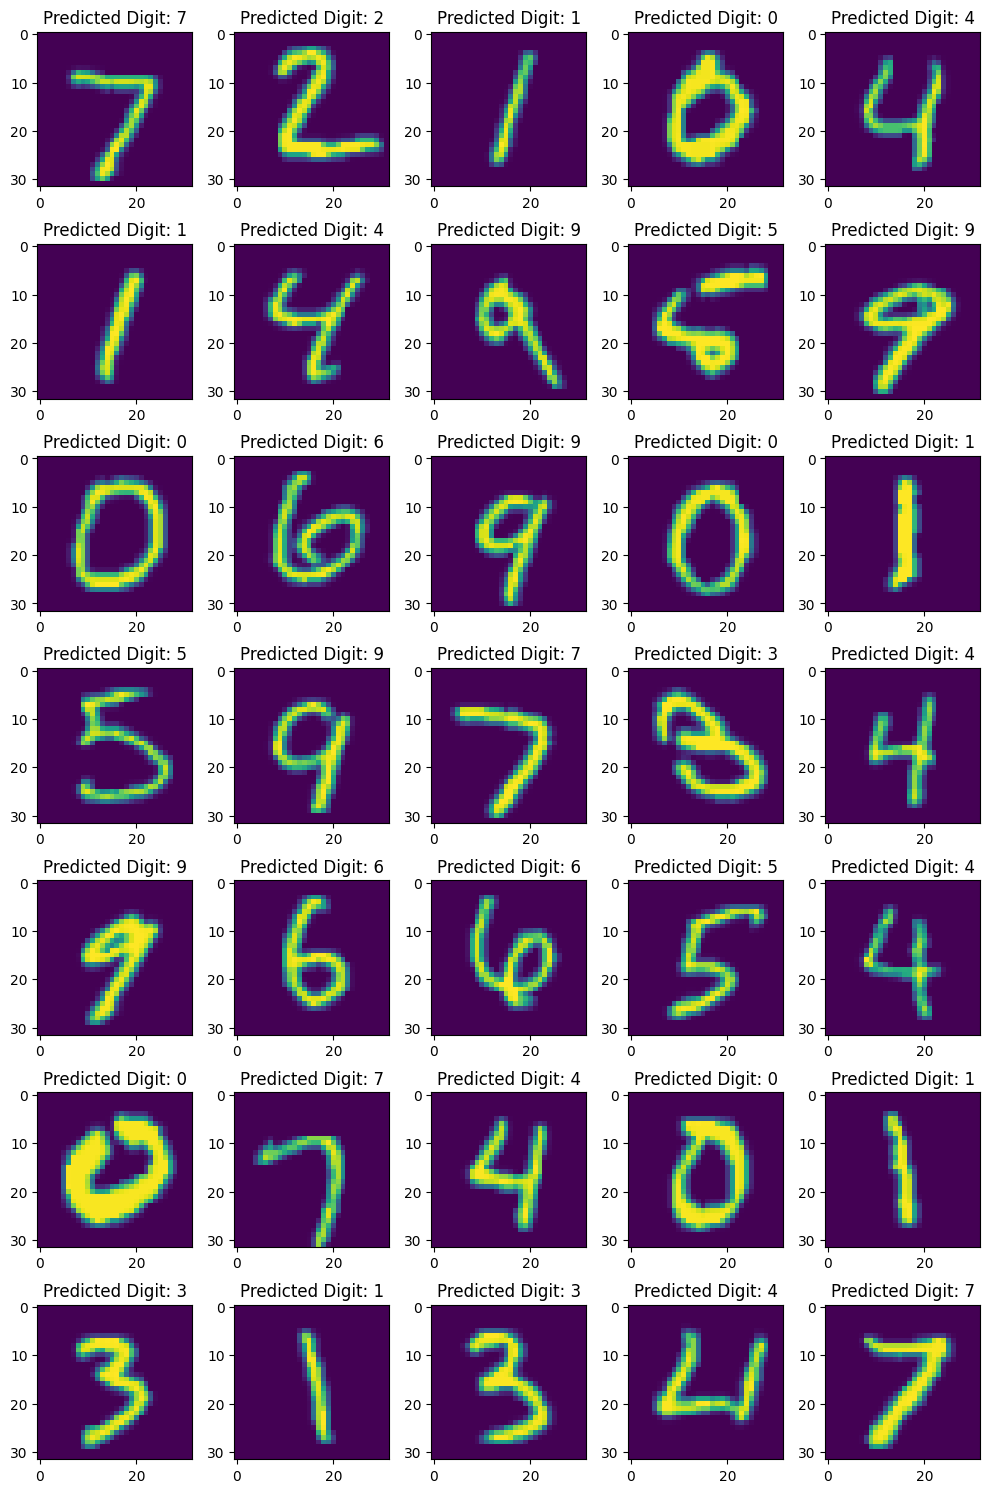

In [79]:
xs, ys = test_ds[0:2000]
ypred = f(xs).argmax(axis = 1)
fig, ax = plt.subplots(10, 4, figsize = (10, 15))
for i in range(35):
    plt.subplot(7, 5, i + 1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {ypred[i]}')
fig.tight_layout()
plt.show()

In [80]:
def compute_accuracy(model, dataset):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataset:
            y = y.type(torch.LongTensor)
            pred = model(x)
            true_labels = torch.argmax(y, dim = 1)
            correct += torch.eq(pred.argmax(1), true_labels).sum().item()
            total += true_labels.size(0)
    accuracy = correct / total
    return accuracy

In [81]:
train_accuracy = compute_accuracy(f, train_dl)
test_accuracy = compute_accuracy(f, test_dl)
print(f'Training Accuracy: {train_accuracy * 100}%')
print(f'Test Accuracy: {test_accuracy * 100}%')

Training Accuracy: 98.51333333333334%
Test Accuracy: 97.14%


In [82]:
torch.save(f.state_dict(), 'model.pth')